# Applied Data Analysis: CMU Movie Summary Corpus

## Abstract

## Research questions

We can investigate whether factors like movie genre, runtime, release date, or language influence box office revenue. 

**Basics questions**
- Do action films generate more revenue than dramas? 
- Does a film’s runtime have an impact on its financial performance? 
- Does movies released in the summer or during winter holiday seasons perform better than those released at other times of the year. 

**Correlation questions**
- Is there a correlation between certain genres and higher revenue? 
- What are the most common predictors of a film’s financial success? 

**Output model** \
By using machine learning models like linear regression, we can create a predictive model for box office success based on historical data. 
- Can we predict a new film’s box office revenue based on its genre, language, runtime, and cast? 


Comparing the actual and predicted box office results, it could provide insight into the key factors that influence financial success in the film industry

## Dataset Details
This dataset contains metadata and plot summaries for over 42,000 movies. The dataset is a rich resource for exploring relationships between movies, characters, and plot content.

- **Name**: CMU Movie Summary Corpus
- **Source**: [CMU Movie Summary Corpus Dataset](https://www.cs.cmu.edu/~ark/personas/)
- **Size**: 46 MB (compressed)
- **Typology**: Text + Graphs + Numerical Data
- **Tags**: Movies, Characters, Plot Summaries, Metadata

The dataset contains:
- **Movie Metadata**: Information about the movies such as titles, genres, release dates.
- **Character Metadata**: Details about the characters in each movie.
- **Plot Summaries**: Textual summaries of movie plots extracted from Wikipedia.

You can read more about the dataset in the paper: [Bamman et al., 2013](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf).

## First analsysis, understanding the data
In this section, we will begin by loading the dataset and performing some initial exploratory data analysis (EDA). This will help us understand the structure and content of the data, identify any missing values, and get a sense of the distributions and relationships between different variables.

In [101]:
# Imports
import os
import importlib
import src.data.CMU_dataset_dataloader as CMU_dataset_dataloader
import matplotlib.pyplot as plt

importlib.reload(CMU_dataset_dataloader)

# Constants
CMU_DATA_PATH_INITIAL = 'data/initial/'

In [102]:
# Load the plot summaries
print("Plot Summaries:")
plots = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'plot_summaries.txt', categories=['movie_id', 'summary'])
df_plots = plots.data
print(plots.data.sample(5))

# Load the movie metadata
print("\nMovie Metadata:")
categories = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres'
    ]
movies = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'movie.metadata.tsv', categories=categories)
df_movies = movies.data
print(movies.data.sample(5))

# Load the character metadata
print("\nCharacter Metadata:")
categories = [
    'wikipedia_movie_id', 
    'freebase_movie_id', 
    'release_date', 
    'character_name', 
    'actor_birth', 
    'actor_gender', 
    'actor_height', 
    'actor_ethnicity', 
    'actor_name', 
    'actor_age', 
    'freebase_character_actor_id', 
    'freebase_character_id', 
    'freebase_actor_id'
    ]
characters = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'character.metadata.tsv', categories=categories)
df_characters = characters.data
print(characters.data.sample(5))

Plot Summaries:
       movie_id                                            summary
19977  11361834  Alex , a 16-year-old skateboarder, rides a fre...
5426    3783131  In 1974, during the final days of the Vietnam ...
6434     261236  Eva, an upper class housewife, becomes frustra...
9000   28422883  In pre-World War I London, handsome young avia...
24836  14881515  For 1400 years the Spiritual Guardians have wa...

Movie Metadata:
       wikipedia_movie_id freebase_movie_id       movie_name release_date  \
8100             31156448        /m/0gh6h9k  Soundarya Pooja         1973   
19375             5463363         /m/0dm_32          Korczak   1990-05-06   
60937            30372098        /m/0g5pzbw      Fumō Chitai   1976-08-14   
36763            10637508        /m/02qkw99  Geet Gaata Chal   1980-05-30   
47806             3092405         /m/08qwy4  Merry Christmas         2005   

       box_office_revenue  runtime  \
8100                  NaN      NaN   
19375                 NaN 

In [103]:
import pandas as pd
import json

# Plot summaries pre-processing

# missing values
assert df_plots['summary'].isnull().sum() == 0
assert df_plots['movie_id'].isnull().sum() == 0

# Average plot summary length
df_plots['summary_length'] = df_plots['summary'].apply(len)
print(df_plots['summary_length'].describe())

# ==> very heterogeneous lengths 

# Print the preprocessed summaries
print(df_plots.sample(5))

count    42303.000000
mean      1784.034300
std       1808.925641
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: summary_length, dtype: float64
       movie_id                                            summary  \
10640  27280443  A woman reporter helps an inspector solve the ...   
31420   3053795  In 1998 Danny, Mitch, Gil and Rory, formerly k...   
39835  31839313  The film's main protagonist is the young and e...   
39059   6883275  The plot revolves around billionaire Jean-Marc...   
12589   3644330  The Blood of a Poet is divided into four secti...   

       summary_length  
10640             818  
31420             761  
39835            4084  
39059             733  
12589            1829  


In [104]:
# Movie metadata pre-processing

# Removing freebase (deprecated)
if 'freebase_movie_id' in df_movies.columns:
    df_movies.drop(columns=['freebase_movie_id'], inplace=True)

# missing values
#df_movies.drop_duplicates(inplace=True)
df_movies = df_movies.dropna()

assert df_movies['wikipedia_movie_id'].isnull().sum() == 0
assert df_movies['movie_name'].isnull().sum() == 0
assert df_movies['release_date'].isnull().sum() == 0
assert df_movies['box_office_revenue'].isnull().sum() == 0
assert df_movies['runtime'].isnull().sum() == 0
assert df_movies['languages'].isnull().sum() == 0
assert df_movies['countries'].isnull().sum() == 0
assert df_movies['genres'].isnull().sum() == 0

# Format release date
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')

def convert_to_dict(dict_str):
    if not isinstance(dict_str, str):
        return dict_str
    
    dict_str = dict_str.replace("'", '"')
    try:
        return json.loads(dict_str)
    except json.JSONDecodeError as e:
        return {} 

# Extracting the language values for all rows
df_movies['languages'] = df_movies['languages'].apply(convert_to_dict)
df_movies['countries'] = df_movies['countries'].apply(convert_to_dict)
df_movies['genres'] = df_movies['genres'].apply(convert_to_dict)

# Must check for empty dictionaries ??

df_movies.sample(5)

C:\Users\USER\AppData\Local\Temp\ipykernel_18096\2363625021.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')
C:\Users\USER\AppData\Local\Temp\ipykernel_18096\2363625021.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['languages'] = df_movies['languages'].apply(convert_to_dict)
C:\Users\USER\AppData\Local\Temp\ipykernel_18096\2363625021.py:35: SettingWithCopyWarning: 
A value is trying to be set on a cop

,wikipedia_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
839,5240350,Big Bad Mama,1974-09-19,4000000.0,83.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/0lsxr': 'Crime Fiction', '/m/03btsm8': 'A..."
49179,106117,Thelma & Louise,NaT,45360915.0,128.0,{'/m/02h40lc': 'English Language'},"{'/m/09c7w0': 'United States of America', '/m/...","{'/m/0lsxr': 'Crime Fiction', '/m/06w2n3t': 'F..."
25829,3132637,Hell's Island,1955-05-06,1000000.0,84.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/03k9fj': 'Advent..."
41754,2400255,All the Right Moves,1983-10-21,17233166.0,90.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01z02hx': 'Sports', '/m/07s9rl0': 'Drama'..."
14453,612052,Spider-Man 2,2004-06-25,783766341.0,127.0,"{'/m/01r2l': 'Chinese language', '/m/02h40lc':...",{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."



## Continued Analysis on Factors Influencing Box Office Revenue

Following the initial exploration and preprocessing, this next stage of analysis aims to identify key predictors for box office revenue through feature data analysis, modeling, and evaluation. 
This will involve features such as **release seasons**, **genre**, **runtime**, and **language**, followed by building a linear regression model and evaluating its performance.

### Step-by-Step Goals:

1. **Exploratory Data Analysis (EDA)**: 
   - Display average box office revenue by release season (summer, winter holiday, other).
   - Display highest 20 average box office revenue by genre.
   - Analyze revenue by runtime to see if longer or shorter films tend to perform better.
   - Display highest 20 average box office revenue by language.

2. **Comment the obtained results**: 
   - Looking at the plots generated before comment the obtained results taking into account observation and possible causes.

3. **Model Training**: 
   - Fit a linear regression model using the features analyzed (release season, genre, runtime and language). 

4. **Evaluation**: 
   - Use error metrics to validate model predictions.
   - Interpret the most influential factors based on model coefficients or feature importance scores.



### Display average box office revenue by release season (summer, holiday, other).

Average Box Office Revenue by Release Season:
release_season
Holiday    5.219552e+07
Other      3.962152e+07
Summer     7.624119e+07
Name: box_office_revenue, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_18096\555912501.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['release_season'] = df_movies['release_date'].apply(categorize_release_season)


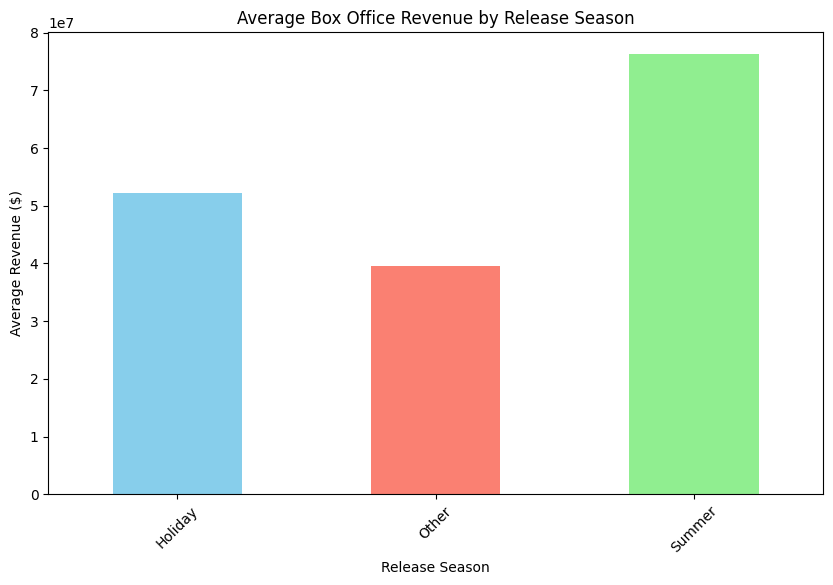

In [105]:
# Define a function to categorize release dates into seasons
def categorize_release_season(date):
    if date.month in [6, 7, 8]:  # Summer months
        return 'Summer'
    elif date.month in [1, 12]:  # Winter holiday
        return 'Holiday'
    else:
        return 'Other'

# Apply the function to create a 'release_season' column
df_movies['release_season'] = df_movies['release_date'].apply(categorize_release_season)

# Calculate average revenues for each season
avg_revenues_by_season = df_movies.groupby('release_season')['box_office_revenue'].mean()

# Print the average revenues by season
print("Average Box Office Revenue by Release Season:")
print(avg_revenues_by_season)

# Plot the average revenues by release season
plt.figure(figsize=(10, 6))
avg_revenues_by_season.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Average Box Office Revenue by Release Season')
plt.xlabel('Release Season')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

### Analysis of Average Box Office Revenue by Release Season

The results indicate the following average revenues:

- **Holiday**: $52.20 million
- **Summer**: $76.24 million
- **Other**: $39.62 million

#### Observations

1. **Higher Revenue in Summer and Holiday Seasons**: Movies released during the summer and holiday seasons tend to generate nearly double the revenue of films released during other times. This trend suggests that these peak periods are associated with higher box office performance.

2. **Lower Revenue for Other Seasons**: Films released outside the summer and holiday months have an average revenue of about $39.62 million, noticeably lower than those released during peak seasons.

#### Possible Causes

1. **Increased Audience Availability**: During the summer and holiday breaks, more people are available for leisure activities, making them more likely to attend movies. This larger audience availability can significantly boost box office revenue.

2. **Strategic Releases**: Studios often schedule their major, high-budget, or highly anticipated films for these peak seasons to capture larger audiences. Action-packed blockbusters and family-friendly films are commonly released during these times, appealing to a broad audience.

3. **Marketing Efforts**: Studios usually invest heavily in marketing campaigns leading up to summer and holiday releases, which builds awareness and anticipation. This increased promotion can lead to higher attendance.

4. **Genre Preferences**: Movies released during summer and holiday seasons are often action films, family-friendly titles, or major franchise installments, which traditionally perform well at the box office. This genre trend could contribute to the higher average revenues during these seasons.

5. **Competitive Advantage**: Although peak seasons bring more competition, the expanded audience size during these times may offset the risk, making summer and holiday releases more profitable for studios.


### Display highest 20 average box office revenue by genre.


C:\Users\USER\AppData\Local\Temp\ipykernel_18096\1607232522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['primary_genre'] = df_movies['genres'].apply(lambda x: max(x.values(), key=lambda v: v) if isinstance(x, dict) and x else 'Unknown')


Average Box Office Revenue by Top 20 Genres:
primary_genre
Disaster                   4.944715e+08
Space opera                4.231513e+08
Costume Adventure          3.331073e+08
Space western              2.664660e+08
Vampire movies             2.474483e+08
Fantasy Adventure          2.442253e+08
Sword and sorcery films    1.961659e+08
Fantasy Comedy             1.608097e+08
Fantasy                    1.404188e+08
Tragedy                    1.402294e+08
Swashbuckler films         1.254296e+08
Remake                     1.197325e+08
Unknown                    1.150944e+08
Holiday Film               1.121158e+08
Time travel                1.096620e+08
Inspirational Drama        1.036318e+08
Superhero movie            1.025472e+08
New Hollywood              1.020639e+08
Mystery                    9.810977e+07
Wuxia                      8.764117e+07
Name: box_office_revenue, dtype: float64


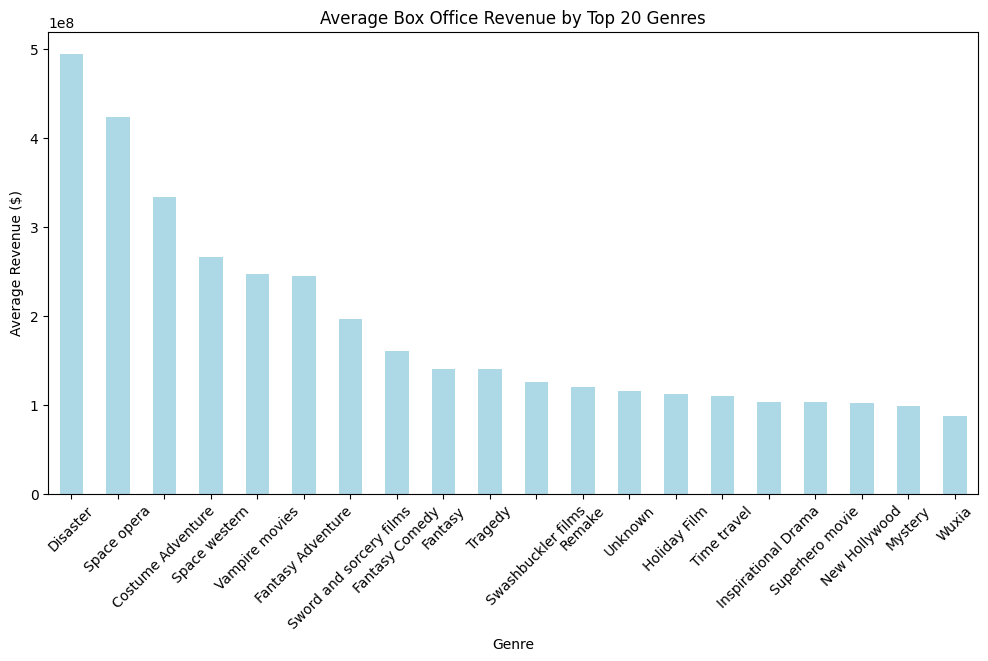

In [106]:
# Extract the primary genre name
df_movies['primary_genre'] = df_movies['genres'].apply(lambda x: max(x.values(), key=lambda v: v) if isinstance(x, dict) and x else 'Unknown')

# Calculate average revenue by primary genre
avg_revenues_by_genre = df_movies.groupby('primary_genre')['box_office_revenue'].mean()

# Select the top 20 genres with the highest average revenue
top_20_genres = avg_revenues_by_genre.sort_values(ascending=False).head(20)

# Print the average revenue by genre
print("Average Box Office Revenue by Top 20 Genres:")
print(top_20_genres)

# Plot the average revenue by genre
plt.figure(figsize=(12, 6))
top_20_genres.plot(kind='bar', color='lightblue')
plt.title('Average Box Office Revenue by Top 20 Genres')
plt.xlabel('Genre')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

### Analysis of Average Box Office Revenue by Genre

The results indicate the following top average revenues by genre:

- **Disaster**: $494.47 million
- **Space Opera**: $423.15 million
- **Costume Adventure**: $333.11 million
- **Space Western**: $266.47 million
- **Vampire Movies**: $247.45 million

#### Observations

1. **High Revenue for Genre-Specific Blockbusters**: Disaster, space opera, and costume adventure films show the highest average revenues, all above $300 million. These genres often involve high budgets and large-scale productions, appealing to broad audiences through spectacular visuals and thrilling storylines.

2. **Fantasy and Adventure Appeal**: Many genres in the top 20, such as fantasy adventure, sword and sorcery, and swashbuckler films, fall under the fantasy and adventure categories. These genres tend to attract diverse audiences, from families to adult viewers, likely contributing to their high average box office performance.

3. **Performance of Supernatural Themes**: Genres like vampire movies and fantasy comedy also perform well, suggesting that supernatural and otherworldly themes resonate strongly with audiences. These themes often lend themselves to franchise building and sequels, which can enhance their overall box office returns.

4. **Broad Appeal of Superhero and Inspirational Dramas**: Genres like superhero movies and inspirational dramas also feature among the high-revenue genres. The strong following for superhero films and the emotional appeal of inspirational stories can draw substantial audiences, especially when paired with well-known actors and directors.

5. **Lower Revenue for Less-Common Genres**: Although still in the top 20, genres like wuxia and mystery show comparatively lower revenues, with averages below $100 million. These genres may have dedicated fan bases but often lack the widespread appeal of high-budget blockbusters.

#### Possible Causes

1. **Audience Preference for High-Production Genres**: Genres with high production values, such as disaster and space opera films, generally have larger budgets that allow for impressive visual effects, drawing audiences seeking thrilling cinematic experiences.

2. **Franchise and Sequel Potential**: Genres with established franchise potential, like space opera and superhero movies, consistently perform well. The brand recognition and continuity associated with these genres can drive repeat viewership and loyalty.

3. **Marketing and Distribution**: Big-budget films in genres like disaster, fantasy, and space opera typically receive extensive marketing support, leading to higher visibility. Wide global distribution further enhances their reach and contributes to their high box office revenue.

4. **Genre-Specific Appeal**: Certain genres, such as inspirational drama and holiday films, may appeal to niche audiences but still generate high revenue due to their focused, emotional storytelling. These genres may resonate particularly well with audiences seeking uplifting or seasonal content.

5. **Cross-Demographic Appeal**: Genres like costume adventure and fantasy often appeal to various demographic groups, from families to younger audiences. This broad appeal can contribute to stronger box office performance, as these genres are accessible to diverse age groups.

### Analyze revenue by runtime to see if longer or shorter films tend to perform better.


C:\Users\USER\AppData\Local\Temp\ipykernel_18096\1882268941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['runtime_category'] = pd.qcut(df_movies['runtime'], q=3, labels=["Short", "Medium", "Long"])
C:\Users\USER\AppData\Local\Temp\ipykernel_18096\1882268941.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_revenue_by_runtime = df_movies.groupby('runtime_category')['box_office_revenue'].mean()


Average Box Office Revenue by Runtime Category:
runtime_category
Short     3.125696e+07
Medium    3.876583e+07
Long      7.821180e+07
Name: box_office_revenue, dtype: float64

Runtime definitions based on quantiles:
- Short: ≤ 96.0 minutes
- Medium: 97.0-110.0 minutes
- Long: > 111.0 minutes


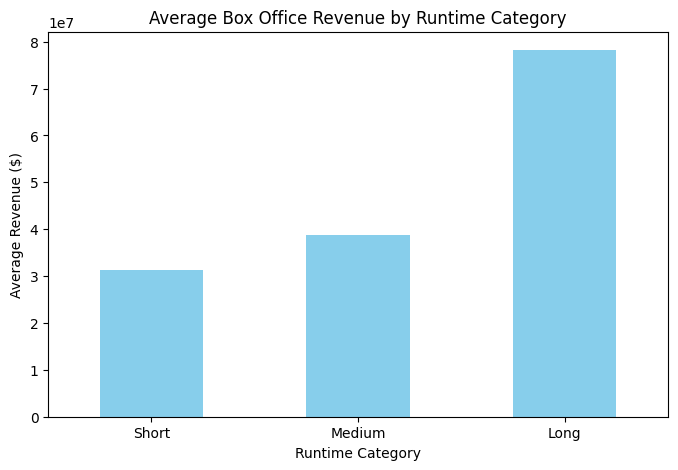

In [107]:
# Define runtime bins based on quantiles for equal-sized groups
df_movies['runtime_category'] = pd.qcut(df_movies['runtime'], q=3, labels=["Short", "Medium", "Long"])

# Verify the approximate runtime boundaries for each category
short_max = df_movies[df_movies['runtime_category'] == "Short"]['runtime'].max()
medium_min = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].min()
medium_max = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].max()
long_min = df_movies[df_movies['runtime_category'] == "Long"]['runtime'].min()

# Calculate average revenue by runtime category
avg_revenue_by_runtime = df_movies.groupby('runtime_category')['box_office_revenue'].mean()

# Print the average revenue by runtime category
print("Average Box Office Revenue by Runtime Category:")
print(avg_revenue_by_runtime)
print(f"\nRuntime definitions based on quantiles:\n- Short: ≤ {short_max} minutes\n- Medium: {medium_min}-{medium_max} minutes\n- Long: > {long_min} minutes")

# Plot the average revenue by runtime category
plt.figure(figsize=(8, 5))
avg_revenue_by_runtime.plot(kind='bar', color='skyblue')
plt.title('Average Box Office Revenue by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=0)
plt.show()


### Analysis of Average Box Office Revenue by Film Runtime

The runtime categories, divided into equal-sized groups based on quantiles, are defined as follows:

- **Short Films**: Runtime of 96 minutes or less
- **Medium Films**: Runtime between 97 and 110 minutes
- **Long Films**: Runtime greater than 111 minutes

The average box office revenues based on these runtime categories are as follows:

- **Short Films**: $31.26 million
- **Medium Films**: $38.77 million
- **Long Films**: $78.21 million

#### Observations

1. **Significantly Higher Revenue for Longer Films**: Films with a runtime over 111 minutes ("Long") have a considerably higher average revenue, nearly double that of medium-length films and more than double that of short films. This suggests that audiences may be more inclined to invest in longer, more immersive film experiences.

2. **Moderate Increase for Medium-Length Films**: Films with runtimes between 97 and 110 minutes ("Medium") generate slightly more revenue than short films. This trend indicates a slight preference for medium-length films over shorter ones, possibly because they allow more depth without demanding too much time from the audience.

3. **Lower Revenue for Short Films**: Films with runtimes of 96 minutes or less ("Short") yield the lowest average revenue, which may suggest a limited appeal, particularly for genres where more time is typically beneficial for storytelling.

#### Possible Causes

1. **Enhanced Storytelling in Long Films**: Longer runtimes allow for more detailed narratives and character development, which can be particularly engaging in genres like action, fantasy, and drama, potentially leading to higher audience satisfaction and ticket sales.

2. **Higher Production Value**: Longer films may often have larger production budgets, which can contribute to high-quality visuals, effects, and top-tier cast members. These elements often appeal to audiences and justify higher ticket prices.

3. **Genre and Audience Expectations**: Many genres that typically perform well, such as action, fantasy, and adventure, tend to have longer runtimes, allowing for complex plot development and extensive world-building. This trend may drive higher revenue for longer films.

4. **Audience Willingness to Commit Time**: Longer films may attract dedicated audiences who value a full cinematic experience, while shorter films may appeal more to casual viewers, resulting in lower average box office revenue.

### Display highest 10 average box office revenue by language.

C:\Users\USER\AppData\Local\Temp\ipykernel_18096\2790707801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['primary_language'] = df_movies['languages'].apply(lambda x: max(x.values(), key=lambda v: v) if isinstance(x, dict) and x else 'Unknown')


Average Box Office Revenue by Top 10 Languages:
primary_language
Old English language     7.474568e+08
Greek Language           4.892928e+08
Swiss German Language    4.859308e+08
Sinhala Language         3.331073e+08
Hmong language           2.699582e+08
Sicilian Language        2.685000e+08
Picard Language          2.451432e+08
Zulu Language            2.428868e+08
Gaelic                   2.040412e+08
Sioux language           1.849910e+08
Name: box_office_revenue, dtype: float64


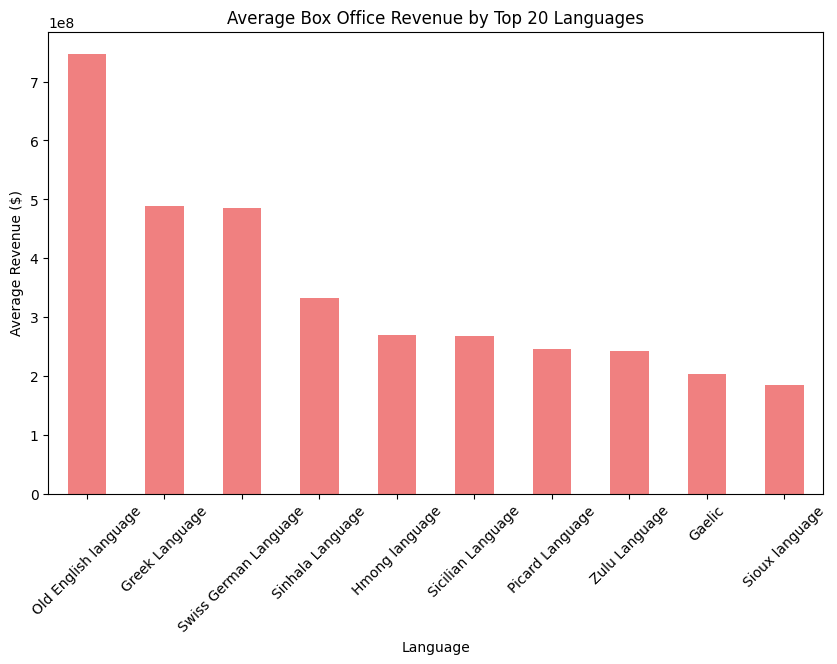

In [108]:
# Extract the primary language name
df_movies['primary_language'] = df_movies['languages'].apply(lambda x: max(x.values(), key=lambda v: v) if isinstance(x, dict) and x else 'Unknown')

# Calculate average revenue by primary language
avg_revenue_by_language = df_movies.groupby('primary_language')['box_office_revenue'].mean()

# Select the top 20 languages with the highest average revenue
top_20_languages = avg_revenue_by_language.sort_values(ascending=False).head(10)

# Print the average revenue by language
print("Average Box Office Revenue by Top 10 Languages:")
print(top_20_languages)

# Plot the average revenue by language
plt.figure(figsize=(10, 6))
top_20_languages.plot(kind='bar', color='lightcoral')
plt.title('Average Box Office Revenue by Top 20 Languages')
plt.xlabel('Language')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

### Analysis of Average Box Office Revenue by Language

The average box office revenues based on the primary language of the films are as follows:

- **Old English Language**: $747.46 million
- **Greek Language**: $489.29 million
- **Swiss German Language**: $485.93 million
- **Sinhala Language**: $333.11 million
- **Hmong Language**: $269.96 million
- **Sicilian Language**: $268.50 million
- **Picard Language**: $245.14 million
- **Zulu Language**: $242.89 million
- **Gaelic**: $204.04 million
- **Sioux Language**: $184.99 million

#### Observations

1. **Dominance of Old English Films**: Films in Old English yield the highest average revenue, suggesting a robust market for films that leverage historical or cultural themes associated with this language. This may be indicative of both niche audiences and potential global appeal.

2. **Significant Revenue from Greek and Swiss German Films**: The substantial average revenues from Greek and Swiss German films point to the successful commercialization of films in these languages, possibly due to strong cultural narratives or diasporic audiences.

3. **Niche Markets for Lesser-Known Languages**: Languages such as Sinhala and Hmong, while generating lower average revenues, highlight the existence of niche markets. These languages may attract dedicated audiences interested in regional storytelling and representation.

#### Possible Causes

1. **Cultural Resonance**: Films in languages like Old English and Greek may resonate more deeply with audiences who appreciate historical and culturally rich narratives, contributing to higher box office performance.

2. **Diverse Audience Reach**: The presence of significant diasporic communities can drive demand for films in specific languages, as seen with Greek and Swiss German films. These audiences are often eager to engage with content that reflects their heritage.

3. **Engagement with Unique Themes**: Films in lesser-known languages often explore themes that are not typically covered in mainstream cinema, allowing them to carve out a distinct audience. The appeal of unique storytelling may lead to dedicated viewership, even if overall revenues are lower.

4. **Festival Circuit Success**: Many films in niche languages tend to perform well in film festivals, which can enhance their visibility and reputation, potentially boosting their box office revenue over time through word-of-mouth and critical acclaim.